# Kernel - SHAP

Below is code written to compute SHAP values for the QSVC Quantum Kernel

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [59]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os

# import data class
from utilities.dataset_utils import DiabetesData

from qiskit_machine_learning.algorithms import QSVC

# explainability imports
# feature map SHAP
from shap import KernelExplainer
from shap import Explanation
from shap.plots import waterfall

#state fidelity
from qiskit.quantum_info import state_fidelity

# sklearn metrics
from sklearn.metrics import pairwise_distances_argmin_min

# qiskit imports
# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [60]:
np.random.seed(42)  # reproducibility

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [61]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [62]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'models', 'qml-simulator', 'qsvc_best_params.model')

qsvc = QSVC.load(path)

In [63]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

Ranged preprocessing used: MinMaxScaler(feature_range=(-1, 1))

In [64]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [65]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [66]:
# sampler
sampler = Sampler.from_backend(backend)

### Kernel Explainability

In [67]:
# generate kernel used
kernel = qsvc.quantum_kernel

In [68]:
# define a central sample to be used in the SHAP explainer
central_idx = pairwise_distances_argmin_min(np.mean(X_train, axis=0).reshape(1, -1), X_train)[0][0]
central_sample = X_train[central_idx]

In [69]:
# generate background data
background_data = X_train[200:300]

```python
kernel_eval
```
Function that evaluates kernel for each sample compared to fixed reference sample

In [70]:
def kernel_eval(x, ref):
    return np.array([
        kernel.evaluate(np.array([x_i]),
        np.array([ref]))[0, 0] for x_i in x
    ])

```python
qsvc_kernel_shap
```

In [71]:
def qsvc_kernel_shap(quantum_kernel, reference_sample, background_data, x_sample, feature_names=None):
    """
    Compute SHAP values to explain the kernel fidelity between an input sample and a fixed reference sample.
    """
    
    # init explainer
    explainer = KernelExplainer(
        model=lambda x: kernel_eval(x, central_sample),
        data=background_data
    )
    
    # calculate SHAP values from explainer
    shap_values = explainer.shap_values(x_sample.reshape(1, -1), nsamples=500)
        
    plt.figure(figsize=(10, 6))
    
    explanation = Explanation(
        values=shap_values[0],
        data=x_sample,
        base_values=explainer.expected_value,
        feature_names=feature_names
    )
    print(f"Expected Value: {explainer.expected_value}")
    plt.title("SHAP Values for Kernel Fidelity")

    waterfall(explanation, show=True)
    
    plt.tight_layout()
    plt.show()
    
    return shap_values

  0%|          | 0/1 [00:00<?, ?it/s]

Expected Value: 0.35583984375


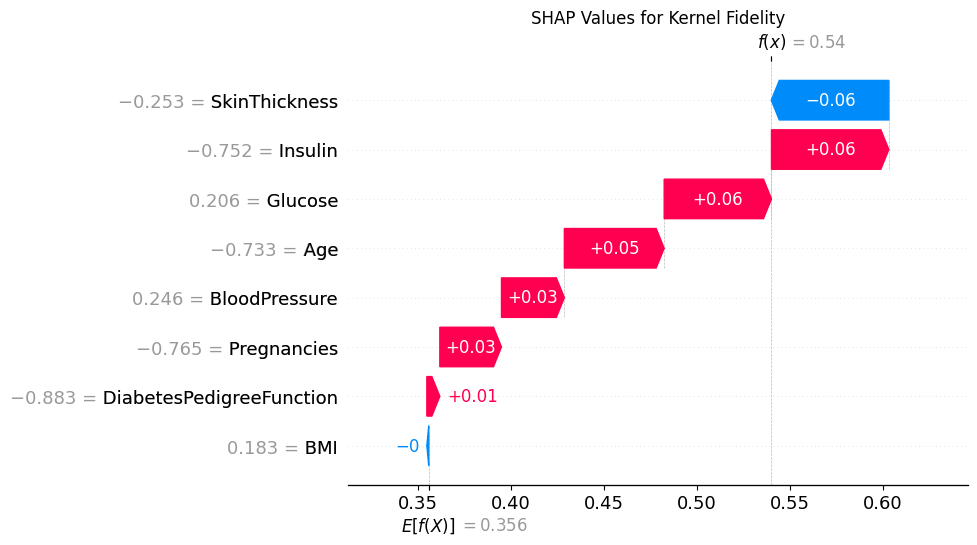

<Figure size 640x480 with 0 Axes>

In [ ]:
test_sample = X_test[50]

# compute the SHAP explanation for the kernel value (i.e., the fidelity between test_sample and reference_sample)
shap_values = qsvc_kernel_shap(
    quantum_kernel=kernel,
    reference_sample=central_sample,
    background_data=background_data,
    x_sample=test_sample,
    feature_names=feature_names
)

Negative value means it sample less similar to the typical patient. positive makes it more similar.



### Class Based Approach

In [73]:
# separate data by class
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

X_class_0 = X_train[class_0_indices]
X_class_1 = X_train[class_1_indices]

In [74]:
# find most central sample in each class
central_idx_0 = pairwise_distances_argmin_min(np.mean(X_class_0, axis=0).reshape(1, -1), X_class_0)[0][0]
central_idx_1 = pairwise_distances_argmin_min(np.mean(X_class_1, axis=0).reshape(1, -1), X_class_1)[0][0]

reference_class_0 = X_class_0[central_idx_0]  # actual data point
reference_class_1 = X_class_1[central_idx_1]  # actual data point

```python
kernel_class_separation_shap
```

In [75]:
def kernel_class_separation_shap(quantum_kernel, X_train, y_train, X_test, y_test, feature_names=None):
    """
    Calculate SHAP values for a QSVC quantum kernel to explain how classical features contribute
    to driving a sample toward the typical profile of each class.
    """
    # Separate training data by class
    X_class_0 = X_train[y_train == 0]
    X_class_1 = X_train[y_train == 1]
    
    # get central sample for each class
    mean_class_0 = np.mean(X_class_0, axis=0).reshape(1, -1)
    central_idx_0 = pairwise_distances_argmin_min(mean_class_0, X_class_0)[0][0]
    central_sample_0 = X_class_0[central_idx_0]
    
    mean_class_1 = np.mean(X_class_1, axis=0).reshape(1, -1)
    central_idx_1 = pairwise_distances_argmin_min(mean_class_1, X_class_1)[0][0]
    central_sample_1 = X_class_1[central_idx_1]
    
    # create stratified background data (equal numbers from each class)
    n_samples = min(50, len(X_class_0), len(X_class_1))
    
    bg_indices_0 = np.random.choice(len(X_class_0), n_samples, replace=False)
    bg_indices_1 = np.random.choice(len(X_class_1), n_samples, replace=False)
    
    background_data = np.vstack([X_class_0[bg_indices_0], X_class_1[bg_indices_1]])
    
    # Create two separate SHAP KernelExplainers, each using its class-specific reference sample
    explainer_0 = KernelExplainer(
        model=lambda x: kernel_eval(x, central_sample_0),
        data=background_data,
        link="identity"
    )
    explainer_1 = KernelExplainer(
        model=lambda x: kernel_eval(x, central_sample_1),
        data=background_data,
        link="identity"
    )
    
    print(f"Expected Value for class 0 reference: {explainer_0.expected_value}")
    print(f"Expected Value for class 1 reference: {explainer_1.expected_value}")
    
    # test samples from each class
    if np.any(y_test == 0) and np.any(y_test == 1):
        test_sample_class_0 = X_test[y_test == 0][0]
        test_sample_class_1 = X_test[y_test == 1][0]
    else:
        print("Warning: Test set doesn't contain samples from both classes. Using training data.")
        test_sample_class_0 = X_class_0[0]
        test_sample_class_1 = X_class_1[0]
    
    # calculate SHAP values with more samples for better approximation
    shap_values_class_0 = explainer_0.shap_values(
        test_sample_class_0.reshape(1, -1), 
        nsamples=500
    )
    
    shap_values_class_1 = explainer_1.shap_values(
        test_sample_class_1.reshape(1, -1), 
        nsamples=500
    )
    
    # Normalize the SHAP values (for better visual comparison)
    abs_values_0 = np.abs(shap_values_class_0[0])
    total_0 = np.sum(abs_values_0)
    normalized_values_0 = shap_values_class_0[0] / total_0 if total_0 > 0 else shap_values_class_0[0]
    
    abs_values_1 = np.abs(shap_values_class_1[0])
    total_1 = np.sum(abs_values_1)
    normalized_values_1 = shap_values_class_1[0] / total_1 if total_1 > 0 else shap_values_class_1[0]
    
    # non-diabetic waterfall graph
    plt.figure(figsize=(12, 8))
    explanation_0 = Explanation(
        values=normalized_values_0,
        base_values=explainer_0.expected_value,
        data=test_sample_class_0,
        feature_names=feature_names
    )
    waterfall(explanation_0, show=False)
    plt.title('Non-Diabetic: Features Contributing to Kernel Fidelity', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # diabetic waterfall graph
    plt.figure(figsize=(12, 8))
    explanation_1 = Explanation(
        values=normalized_values_1,
        base_values=explainer_1.expected_value,
        data=test_sample_class_1,
        feature_names=feature_names
    )
    waterfall(explanation_1, show=False)
    plt.title('Diabetic: Features Contributing to Kernel Fidelity', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return shap_values_class_0, shap_values_class_1


Expected Value for class 0 reference: 0.40651367187500004
Expected Value for class 1 reference: 0.337099609375


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

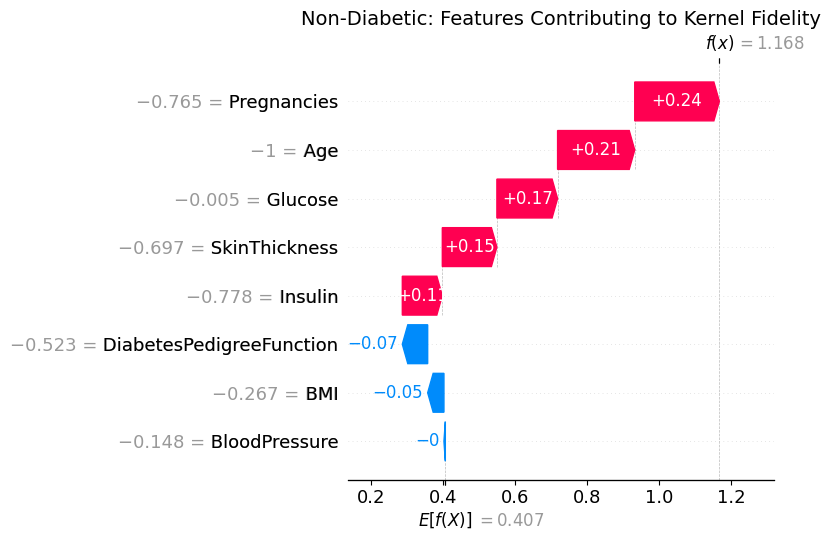

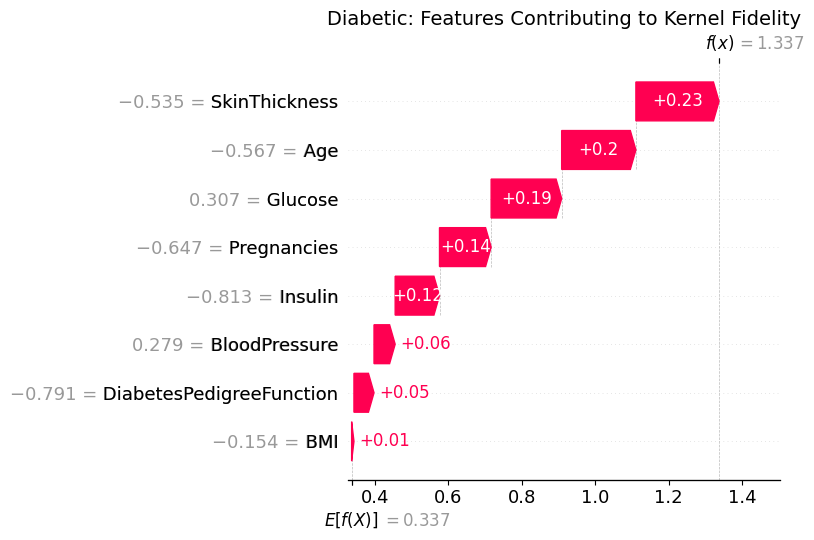

In [76]:
shap_vals_0, shap_vals_1 = kernel_class_separation_shap(
    quantum_kernel=kernel,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=feature_names
)

Shows what features make the sample look more like each class

Features with higher values in both class means they are important for both, but will interact differently with other features to get this outcome.